In [1]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind  # Add ttest_ind import
import csv
import yaml
import random
import re

In [2]:
# Load the processed data
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Hs_Nor-CKD-AKF_scRNA_processed.h5ad")

In [3]:
adata.var

,index,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells
ENSG00000243485,ENSG00000243485,False,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA,5
ENSG00000238009,ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,263
ENSG00000241860,ENSG00000241860,False,ENSG00000241860.7,NCBITaxon:9606,gene,1025,lncRNA,1057
ENSG00000286448,ENSG00000286448,False,ENSG00000286448.1,NCBITaxon:9606,gene,736,lncRNA,8
ENSG00000235146,ENSG00000235146,False,ENSG00000235146.2,NCBITaxon:9606,gene,504,lncRNA,6
...,...,...,...,...,...,...,...,...
ENSG00000277856,ENSG00000277856,False,ENSG00000277856.1,NCBITaxon:9606,gene,294,protein_coding,8
ENSG00000275063,ENSG00000275063,False,ENSG00000275063.1,NCBITaxon:9606,gene,351,protein_coding,33
ENSG00000273554,ENSG00000273554,False,ENSG00000273554.4,NCBITaxon:9606,gene,3345,protein_coding,12
ENSG00000278817,ENSG00000278817,False,ENSG00000278817.1,NCBITaxon:9606,gene,1213,protein_coding,7824


In [4]:
# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

# Change the name of some entries in gene_dict_names to fix plotting errors
gene_dict_names = [re.sub(r'\bC2\b', 'C2_ENSG00000166278', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC3\b', 'C3_ENSG00000125730', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC6\b', 'C6_ENSG00000039537', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC7\b', 'C7_ENSG00000112936', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC9\b', 'C9_ENSG00000113600', name) for name in gene_dict_names]

# Load the tissue type dictionary from the yaml file
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

## Test differential expression of complement genes in different disease states

/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


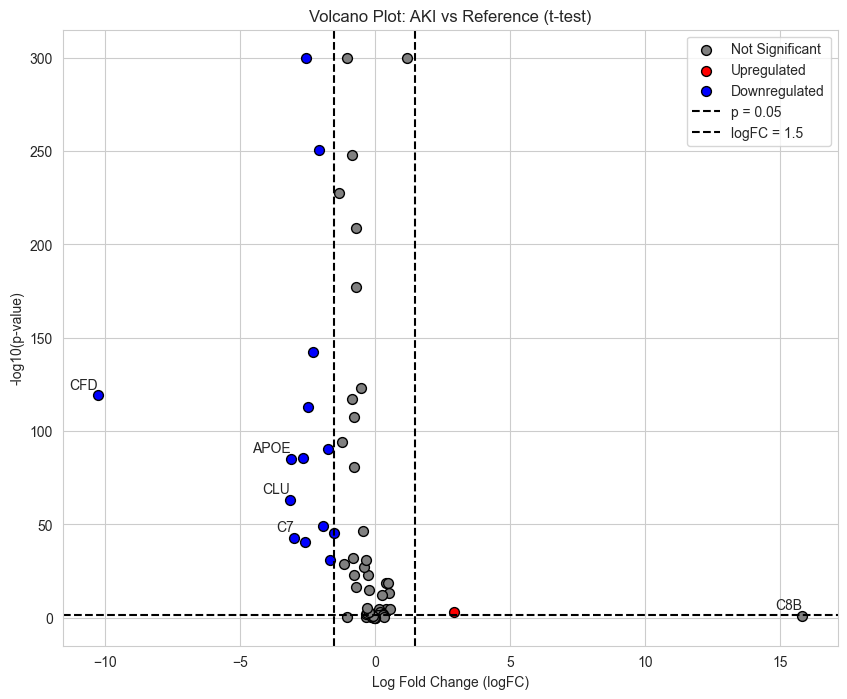

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text

def volcano_plot(
    adata, gene_dict, group1="Reference", group2="AKI",
    logfc_thresh=1.5, pval_thresh=0.05, top_n=5, save_path=None, colors=None, method="t-test"
):
    """
    Creates a volcano plot and returns both the plot and the processed differential expression DataFrame.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    group1 : str, optional
        The reference group (default: 'Reference').
    group2 : str, optional
        The experimental/disease group to compare against group1 (default: 'AKI').
    logfc_thresh : float, optional
        Log fold change threshold (default: 1.5).
    pval_thresh : float, optional
        P-value threshold (default: 0.05).
    top_n : int, optional
        Number of genes to annotate (default: 5).
    save_path : str, optional
        If specified, saves the figure to this path.
    colors : dict, optional
        Custom colors for plot categories (default: None).
    method : str, optional
        Method for differential expression analysis (default: 't-test').

    Returns
    -------
    tuple
        (matplotlib.figure.Figure, pd.DataFrame)
        - Figure object containing the volcano plot.
        - DataFrame with differential expression results.
    """

    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    if "diseasetype" not in adata.obs:
        raise ValueError("`diseasetype` column missing in adata.obs.")

    # Subset data
    adata_disease = adata[adata.obs["diseasetype"].isin([group1, group2])]

    # Use raw if available
    if adata.raw is not None:
        adata_disease = adata.raw.to_adata()[adata.obs["diseasetype"].isin([group1, group2])]

    # Perform DE analysis
    sc.tl.rank_genes_groups(adata_disease, groupby="diseasetype", groups=[group2], reference=group1, method=method)

    if "rank_genes_groups" not in adata_disease.uns:
        raise ValueError("No differential expression results found. Ensure `rank_genes_groups` was run.")

    # Extract results
    de_results = adata_disease.uns["rank_genes_groups"]
    gene_ids, pvals, logfc = de_results["names"][group2], de_results["pvals"][group2], de_results["logfoldchanges"][group2]
    pvals = np.where(pvals == 0, 1e-300, pvals)  # Avoid log(0)

    # Create DataFrame
    volcano_data = pd.DataFrame({
        "Ensembl_ID": gene_ids,
        "logFC": logfc,
        "-log10(p-value)": -np.log10(pvals),
        "Gene_Name": [ensembl_to_gene.get(gid, None) for gid in gene_ids]
    }).dropna(subset=["Gene_Name"])

    # Define significance
    volcano_data["Significance"] = "Not Significant"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] > logfc_thresh), "Significance"
    ] = "Upregulated"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] < -logfc_thresh), "Significance"
    ] = "Downregulated"

    # Default colors
    if colors is None:
        colors = {"Not Significant": "gray", "Upregulated": "red", "Downregulated": "blue"}

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    for sig, color in colors.items():
        subset = volcano_data[volcano_data["Significance"] == sig]
        ax.scatter(subset["logFC"], subset["-log10(p-value)"], c=color, edgecolors="black", label=sig, s=50)

    # Annotate genes
    top_genes_to_annotate = volcano_data.loc[volcano_data["logFC"].abs().nlargest(top_n).index]
    texts = [ax.text(row["logFC"], row["-log10(p-value)"], row["Gene_Name"], fontsize=10, ha="right", va="bottom") for _, row in top_genes_to_annotate.iterrows()]
    adjust_text(texts, arrowprops=dict(arrowstyle="->", lw=1.5))

    # Threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color="black", linestyle="--", label=f"p = {pval_thresh}")
    ax.axvline(x=logfc_thresh, color="black", linestyle="--", label=f"logFC = {logfc_thresh}")
    ax.axvline(x=-logfc_thresh, color="black", linestyle="--")

    # Labels and title
    ax.set_xlabel("Log Fold Change (logFC)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"Volcano Plot: {group2} vs {group1} ({method})")
    ax.legend()

    # Save or return figure
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    else:
        plt.show()

    return fig, volcano_data

# Example usage
fig, df = volcano_plot(adata, gene_dict,group1="Reference", group2="AKI")

In [6]:
gene_dict

{'APOE': 'ENSG00000130203',
 'ATG5': 'ENSG00000057663',
 'ATG7': 'ENSG00000197548',
 'BECN1': 'ENSG00000126581',
 'C1QA': 'ENSG00000173372',
 'C1QB': 'ENSG00000173369',
 'C1QC': 'ENSG00000159189',
 'C1QTNF6': 'ENSG00000133466',
 'C1S': 'ENSG00000182326',
 'C2': 'ENSG00000166278',
 'C3': 'ENSG00000125730',
 'C3AR1': 'ENSG00000171860',
 'C5': 'ENSG00000106804',
 'C5AR1': 'ENSG00000197405',
 'C5AR2': 'ENSG00000134830',
 'C6': 'ENSG00000039537',
 'C7': 'ENSG00000112936',
 'C8A': 'ENSG00000157131',
 'C8B': 'ENSG00000021852',
 'C8G': 'ENSG00000176919',
 'C9': 'ENSG00000113600',
 'CASP1': 'ENSG00000137752',
 'CASP8': 'ENSG00000064012',
 'CD46': 'ENSG00000117335',
 'CD55': 'ENSG00000196352',
 'CD59': 'ENSG00000085063',
 'CFD': 'ENSG00000197766',
 'CFH': 'ENSG00000000971',
 'CFHR1': 'ENSG00000244414',
 'CFHR3': 'ENSG00000116785',
 'CFHR4': 'ENSG00000134365',
 'CFHR5': 'ENSG00000134389',
 'CFI': 'ENSG00000205403',
 'CLU': 'ENSG00000120885',
 'CR1': 'ENSG00000203710',
 'CR2': 'ENSG00000117322',
 

In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text

def volcano_plot(
    adata, gene_dict, group1="Reference", group2="AKI",
    logfc_thresh=1.0, pval_thresh=0.1, top_n=5, save_path=None, colors=None, method="t-test"
):
    """
    Creates a volcano plot and returns both the plot and the processed differential expression DataFrame.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    group1 : str, optional
        The reference group (default: 'Reference').
    group2 : str, optional
        The experimental/disease group to compare against group1 (default: 'AKI').
    logfc_thresh : float, optional
        Log fold change threshold (default: 1.0).
    pval_thresh : float, optional
        P-value threshold (default: 0.1).
    top_n : int, optional
        Number of genes to annotate (default: 5).
    save_path : str, optional
        If specified, saves the figure to this path.
    colors : dict, optional
        Custom colors for plot categories (default: None).
    method : str, optional
        Method for differential expression analysis (default: 't-test').

    Returns
    -------
    tuple
        (matplotlib.figure.Figure, pd.DataFrame)
        - Figure object containing the volcano plot.
        - DataFrame with differential expression results.
    """

    # Flip dictionary: {Gene Name: Ensembl ID} → {Ensembl ID: Gene Name}
    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    if "diseasetype" not in adata.obs:
        raise ValueError("`diseasetype` column missing in adata.obs.")

    # Subset data correctly
    adata_disease = adata[adata.obs["diseasetype"].isin([group1, group2])].copy()

    # Use raw if available
    if adata.raw is not None:
        adata_disease = adata.raw.to_adata()
        adata_disease = adata_disease[adata.obs["diseasetype"].isin([group1, group2])].copy()

    # 🔹 Ensure log-transformed data
    if np.max(adata_disease.X) > 100:  # Likely raw counts if values are very high
        sc.pp.log1p(adata_disease)

    # Perform DE analysis
    sc.tl.rank_genes_groups(adata_disease, groupby="diseasetype", groups=[group2], reference=group1, method=method)

    if "rank_genes_groups" not in adata_disease.uns:
        raise ValueError("No differential expression results found. Ensure `rank_genes_groups` was run.")

    # Extract results safely
    de_results = adata_disease.uns["rank_genes_groups"]
    if group2 not in de_results["names"].dtype.names:
        raise ValueError(f"Differential expression results missing for {group2}.")

    gene_ids = np.array(de_results["names"][group2])
    pvals = np.array(de_results["pvals"][group2])
    logfc = np.array(de_results["logfoldchanges"][group2])

    # Fix p-value issues (avoid log(0))
    pvals = np.maximum(pvals, 1e-300)

    # Create DataFrame
    volcano_data = pd.DataFrame({
        "Ensembl_ID": gene_ids,
        "logFC": logfc,
        "-log10(p-value)": -np.log10(pvals),
        "Gene_Name": [ensembl_to_gene.get(gid, gid) for gid in gene_ids]  # Keep Ensembl ID if name is missing
    })

    # Define significance
    volcano_data["Significance"] = "Not Significant"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] > logfc_thresh), "Significance"
    ] = "Upregulated"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] < -logfc_thresh), "Significance"
    ] = "Downregulated"

    # Debugging print statements
    print("Total genes before filtering:", len(volcano_data))
    print(volcano_data["Significance"].value_counts())

    # Default colors
    if colors is None:
        colors = {"Not Significant": "gray", "Upregulated": "red", "Downregulated": "blue"}

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    for sig, color in colors.items():
        subset = volcano_data[volcano_data["Significance"] == sig]
        ax.scatter(subset["logFC"], subset["-log10(p-value)"], c=color, edgecolors="black", label=sig, s=50)

    # Annotate top genes
    top_genes_to_annotate = volcano_data.loc[volcano_data["logFC"].abs().nlargest(top_n).index]
    texts = [ax.text(row["logFC"], row["-log10(p-value)"], row["Gene_Name"], fontsize=10, ha="right", va="bottom") for _, row in top_genes_to_annotate.iterrows()]
    adjust_text(texts, arrowprops=dict(arrowstyle="->", lw=1.5))

    # Threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color="black", linestyle="--", label=f"p = {pval_thresh}")
    ax.axvline(x=logfc_thresh, color="black", linestyle="--", label=f"logFC = {logfc_thresh}")
    ax.axvline(x=-logfc_thresh, color="black", linestyle="--")

    # Labels and title
    ax.set_xlabel("Log Fold Change (logFC)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"Volcano Plot: {group2} vs {group1} ({method})")
    ax.legend()

    # Save or return figure
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    else:
        plt.show()

    return fig, volcano_data


Total genes before filtering: 31332
Significance
Not Significant    24705
Downregulated       4610
Upregulated         2017
Name: count, dtype: int64


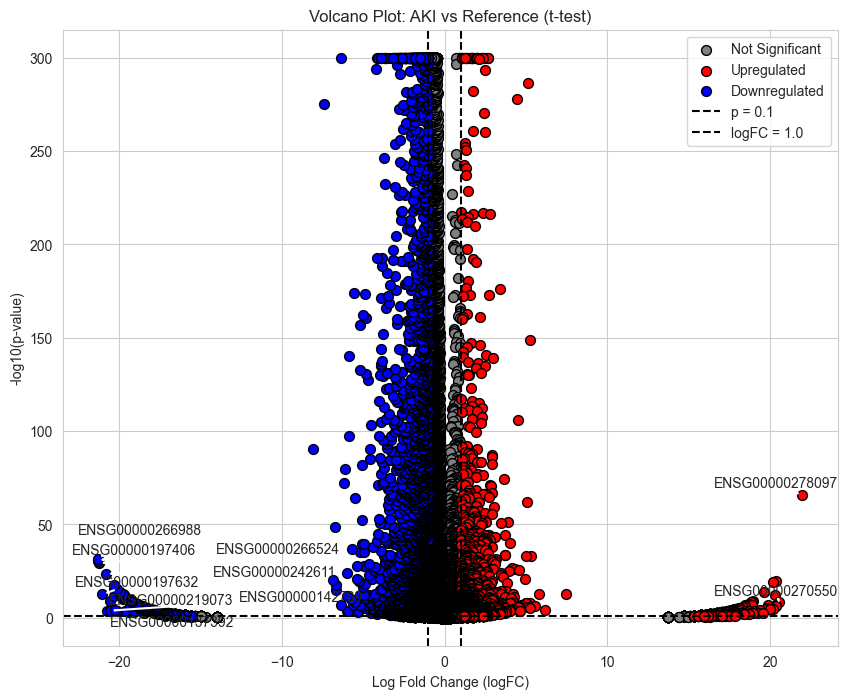

In [17]:
fig, df = volcano_plot(adata, gene_dict, group1="Reference", group2="AKI", top_n=10)


In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text  # For reducing annotation overlap

def volcano_plot(adata, gene_dict, disease, group1='Reference', group2='AKI', logfc_thresh=1.5, pval_thresh=0.05, top_n=5, save_path=None):
    """
    Creates a volcano plot and annotates specific genes from a user-defined dictionary.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    disease : str
        Disease state to plot (e.g., 'AKI', 'CKD').
    group1 : str, optional
        The reference group to compare against (default is 'Reference').
    group2 : str, optional
        The disease group to compare (default is 'AKI').
    logfc_thresh : float, optional
        Minimum log fold change threshold for significance.
    pval_thresh : float, optional
        Maximum p-value threshold for significance.
    top_n : int, optional
        Maximum number of genes from `gene_dict` to annotate based on absolute logFC.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed.
    """
    # Flip dictionary: {Gene Name: Ensembl ID} → {Ensembl ID: Gene Name}
    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    # Subset data
    adata_disease = adata[adata.obs['diseasetype'].isin([group1, group2]), :]

    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata_disease, groupby='diseasetype', groups=[group2], reference=group1, method='t-test')

    # Extract results
    de_results = adata_disease.uns['rank_genes_groups']
    gene_ids = de_results['names'][group2]  # Ensembl IDs
    pvals = de_results['pvals'][group2]
    logfc = de_results['logfoldchanges'][group2]

    # Create DataFrame
    volcano_data = pd.DataFrame({
        'Ensembl_ID': gene_ids,
        'logFC': logfc,
        '-log10(p-value)': -np.log10(pvals)
    })

    # Define significance thresholds
    volcano_data['Significance'] = 'Not Significant'
    volcano_data.loc[(volcano_data['-log10(p-value)'] > -np.log10(pval_thresh)) & (volcano_data['logFC'] > logfc_thresh), 'Significance'] = 'Upregulated'
    volcano_data.loc[(volcano_data['-log10(p-value)'] > -np.log10(pval_thresh)) & (volcano_data['logFC'] < -logfc_thresh), 'Significance'] = 'Downregulated'

    # Plot
    plt.figure(figsize=(10, 8))
    colors = {'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}
    for sig, color in colors.items():
        subset = volcano_data[volcano_data['Significance'] == sig]
        plt.scatter(subset['logFC'], subset['-log10(p-value)'], c=color, alpha=0.6, edgecolors='black', label=sig, s=50)

    # Replace Ensembl IDs with Gene Names using flipped dictionary
    volcano_data['Gene_Name'] = volcano_data['Ensembl_ID'].map(ensembl_to_gene)
    volcano_data = volcano_data.dropna(subset=['Gene_Name'])  # Keep only genes present in the dictionary

    # Select most changed genes from the list
    top_genes_to_annotate = volcano_data.reindex(volcano_data['logFC'].abs().nlargest(top_n).index)

    # Annotate genes with callouts
    texts = []
    for _, row in top_genes_to_annotate.iterrows():
        text = plt.text(row['logFC'], row['-log10(p-value)'], row['Gene_Name'], fontsize=10, ha='right', va='bottom')
        texts.append(text)

    # Adjust text positions to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=1.5))

    # Add threshold lines
    plt.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', label=f'p = {pval_thresh}')
    plt.axvline(x=logfc_thresh, color='black', linestyle='--', label=f'logFC = {logfc_thresh}')
    plt.axvline(x=-logfc_thresh, color='black', linestyle='--')

    # Labels and title
    plt.xlabel('Log Fold Change (logFC)')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Volcano Plot: {group2} vs {group1}')
    plt.legend()

    # Show or save
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_8415/2831578911.py:51: RuntimeWarning: divide by zero encountered in log10
  '-log10(p-value)': -np.log10(pvals)


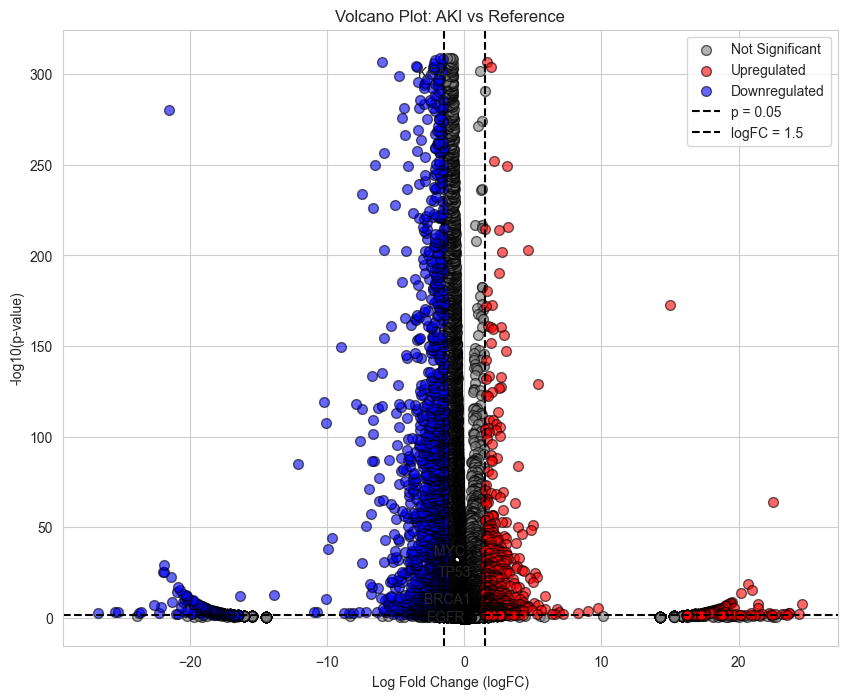

In [19]:
# Example usage with the gene dictionary
volcano_plot(adata, gene_dict, disease='AKI', group1='Reference', group2='AKI', logfc_thresh=1.5, pval_thresh=0.05, top_n=5)


In [25]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text

def volcano_plot(
    adata,
    gene_dict,
    group1="Reference",
    group2="AKI",
    logfc_thresh=1.0,
    pval_thresh=0.1,
    top_n=5,
    save_path=None,
    colors=None,
    method="t-test",
    annotate_fontsize=10,
    annotate_color="black",
    annotate_offset=0.02,
    annotate_method="adjust_text",
    debug=False
):
    """
    Creates a volcano plot and returns both the plot and the processed differential expression DataFrame.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    group1 : str, optional
        The reference group (default: 'Reference').
    group2 : str, optional
        The experimental/disease group to compare against group1 (default: 'AKI').
    logfc_thresh : float, optional
        Log fold change threshold (default: 1.0).
    pval_thresh : float, optional
        P-value threshold (default: 0.1).
    top_n : int, optional
        Number of genes to annotate (default: 5).
    save_path : str, optional
        If specified, saves the figure to this path.
    colors : dict, optional
        Custom colors for plot categories (default: None).
    method : str, optional
        Method for differential expression analysis (default: 't-test').

        Available methods:
        - "t-test": Standard parametric test assuming normality.
        - "t-test_overestim_var": Similar to t-test but with variance overestimation for stricter significance.
        - "wilcoxon": Non-parametric test robust to outliers, recommended for single-cell RNA-seq.
        - "logreg": Logistic regression, useful for finding genes that best classify groups.
    annotation_fontsize : int, optional
        Font size for gene annotations (default: 10).
    annotation_color : str, optional
        Color of annotation text (default: 'black').
    annotation_arrowprops : dict, optional
        Custom properties for annotation arrows (default: None).
        Example: {'arrowstyle': '->', 'lw': 1.5}.

    Returns
    -------
    tuple
        (matplotlib.figure.Figure, pd.DataFrame)
        - Figure object containing the volcano plot.
        - DataFrame with differential expression results.
    """
    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    if "diseasetype" not in adata.obs:
        raise ValueError("`diseasetype` column missing in adata.obs.")

    adata_subset = adata[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if adata.raw is not None:
        adata_subset = adata.raw.to_adata()
        adata_subset = adata_subset[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if np.max(adata_subset.X) > 100:
        sc.pp.log1p(adata_subset)

    sc.tl.rank_genes_groups(adata_subset, groupby="diseasetype", groups=[group2], reference=group1, method=method)

    if "rank_genes_groups" not in adata_subset.uns:
        raise ValueError("No differential expression results found. Ensure `rank_genes_groups` was run.")

    de_results = adata_subset.uns["rank_genes_groups"]
    if group2 not in de_results["names"].dtype.names:
        raise ValueError(f"Differential expression results missing for {group2}.")

    gene_ids = np.array(de_results["names"][group2])
    pvals = np.array(de_results["pvals"][group2])
    logfc = np.array(de_results["logfoldchanges"][group2])

    pvals = np.maximum(pvals, 1e-300)

    volcano_data = pd.DataFrame({
        "Ensembl_ID": gene_ids,
        "logFC": logfc,
        "-log10(p-value)": -np.log10(pvals),
        "Gene_Name": [ensembl_to_gene.get(gid, gid) for gid in gene_ids]
    })

    volcano_data["Significance"] = "Not Significant"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] > logfc_thresh),
        "Significance"
    ] = "Upregulated"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] < -logfc_thresh),
        "Significance"
    ] = "Downregulated"

    if debug:
        print("Total genes:", len(volcano_data))
        print("Significance breakdown:\n", volcano_data["Significance"].value_counts())

    if colors is None:
        colors = {"Not Significant": "gray", "Upregulated": "red", "Downregulated": "blue"}

    fig, ax = plt.subplots(figsize=(10, 8))
    for sig, color in colors.items():
        subset = volcano_data[volcano_data["Significance"] == sig]
        ax.scatter(subset["logFC"], subset["-log10(p-value)"],
                   c=color, edgecolors="black", label=sig, s=50, alpha=0.6)

    top_genes = volcano_data.loc[volcano_data["logFC"].abs().nlargest(top_n).index]
    texts = []

    for _, row in top_genes.iterrows():
        text = ax.text(
            row["logFC"], row["-log10(p-value)"] + annotate_offset, row["Gene_Name"],
            fontsize=annotate_fontsize, color=annotate_color, ha="right", va="bottom"
        )
        texts.append(text)

    if annotate_method == "adjust_text":
        adjust_text(texts, arrowprops=dict(arrowstyle="->", lw=1.5))

    ax.axhline(y=-np.log10(pval_thresh), color="black", linestyle="--", label=f"p = {pval_thresh}")
    ax.axvline(x=logfc_thresh, color="black", linestyle="--", label=f"logFC = {logfc_thresh}")
    ax.axvline(x=-logfc_thresh, color="black", linestyle="--")

    ax.set_xlabel("Log Fold Change (logFC)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"Volcano Plot: {group2} vs {group1} ({method})")
    ax.legend()

    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    else:
        plt.show()

    return fig, volcano_data

In [ ]:
volcano_plot(
    adata,
    gene_dict,
    group1="Reference",
    group2="AKI",
    logfc_thresh=1.0,
    pval_thresh=0.1,
    top_n=5,
    method="wilcoxon")